# Inference
[인공지능을 이용한 의료영상처리 및 실습]  
201902186 여언주  
201903913 황지현

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel]"
!python -c "import matplotlib" || pip install -q matplotlib

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'
     |████████████████████████████████| 714 kB 5.3 MB/s 


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path0 = '/content/drive/MyDrive/data/brats18_train/brats18_train'
dpiv = 80

In [ ]:
from monai.transforms import *
from monai.config import print_config
from monai.data import DataLoader, Dataset, CacheDataset
from monai.utils import *

from monai.losses import DiceLoss
from monai.metrics import DiceMetric
from monai.networks.nets import UNet
from monai.inferers import sliding_window_inference
from monai.networks.layers import Norm

import torch
import torch.nn as nn
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
import os
import glob

In [ ]:
if torch.cuda.is_available():
  device = torch.device('cuda:0')
else:
  device = torch.device('cpu')

print(device)

cuda:0


In [ ]:
device = torch.device("cuda:0")
model = UNet(
    dimensions=3,
    in_channels=1,
    out_channels=2,
    channels=(8, 16, 32, 64),
    strides=(2, 2, 2, 2),
    num_res_units=3,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)

/usr/local/lib/python3.7/dist-packages/monai/networks/nets/unet.py:136: UserWarning: `len(strides) > len(channels) - 1`, the last 1 values of strides will not be used.
  warnings.warn(f"`len(strides) > len(channels) - 1`, the last {delta} values of strides will not be used.")


In [ ]:
root_dir = path0
model.load_state_dict(torch.load(os.path.join(root_dir, f"1.best_metric_model_epoch_80.pth")))

<All keys matched successfully>

In [ ]:
import nibabel as nib
path_out = os.path.join(path0,'valid_out') # the results will be saved in this folder
if os.path.isdir(path_out)==0:
  os.mkdir(path_out)

## test data load

In [ ]:
path1 = "/content/drive/MyDrive/data/brats18_test"

In [ ]:
ts_list = glob.glob(os.path.join(path1,'Brats18*'))
len(ts_list)

20

In [ ]:
ts_ind = np.arange(0,20)
ts_files = [
    {
        "image": os.path.join(ts_list[idx], "t1ce.nii.gz"),
        "label": os.path.join(ts_list[idx], "seg.nii.gz"),
    }
    for idx in ts_ind
]

In [ ]:
ts_transforms = Compose(
    [
      LoadImaged(keys=["image"]),
      AddChanneld(keys=("image")),
      NormalizeIntensityd(keys="image", nonzero=True, channel_wise=True),
      ToTensord(keys=["image"]),
    ]
)

In [ ]:
ts_ds = CacheDataset(data = ts_files, transform = ts_transforms)
ts_loader = DataLoader(ts_ds,batch_size = 1)

Loading dataset: 100%|██████████| 20/20 [00:06<00:00,  3.05it/s]


['/content/drive/MyDrive/data/brats18_test/Brats18_test_02/t1ce.nii.gz']


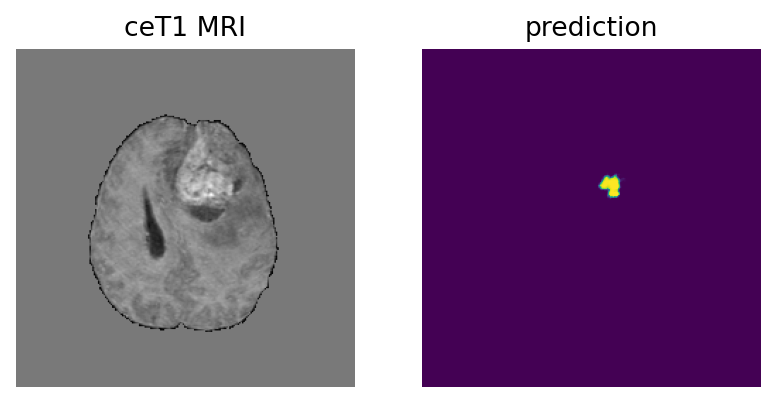

['/content/drive/MyDrive/data/brats18_test/Brats18_test_04/t1ce.nii.gz']


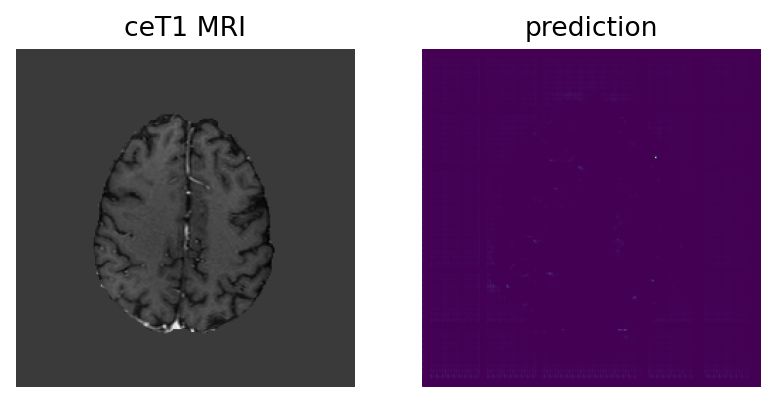

['/content/drive/MyDrive/data/brats18_test/Brats18_test_01/t1ce.nii.gz']


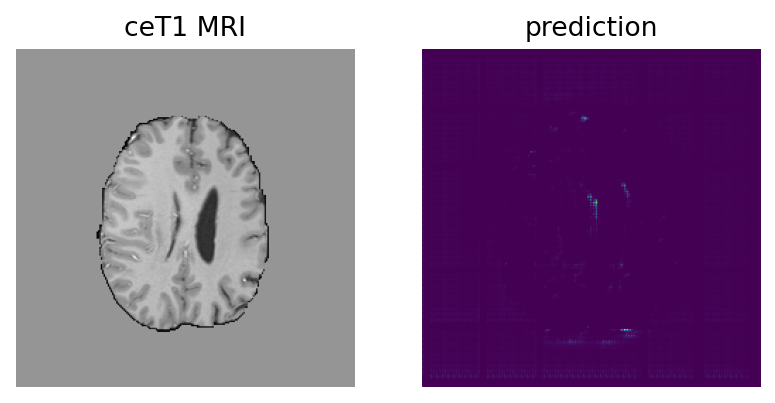

['/content/drive/MyDrive/data/brats18_test/Brats18_test_03/t1ce.nii.gz']


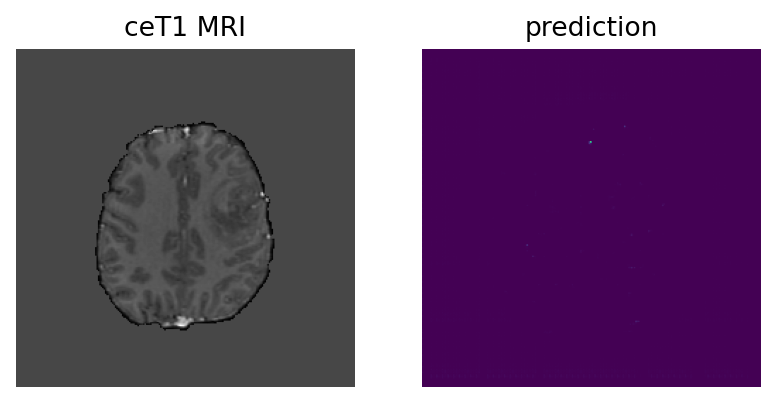

['/content/drive/MyDrive/data/brats18_test/Brats18_test_05/t1ce.nii.gz']


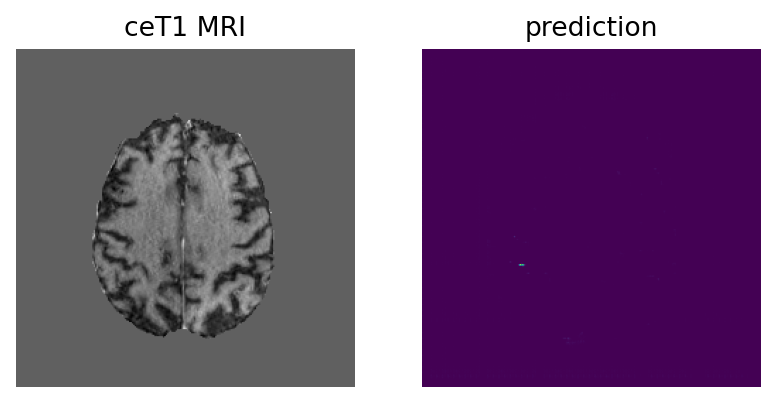

['/content/drive/MyDrive/data/brats18_test/Brats18_test_06/t1ce.nii.gz']


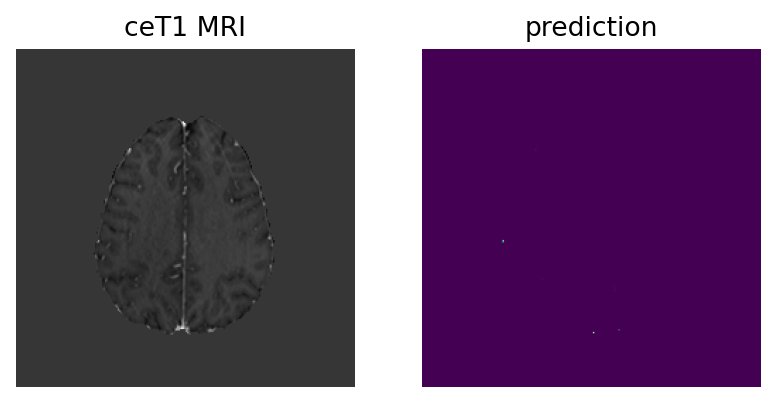

['/content/drive/MyDrive/data/brats18_test/Brats18_test_11/t1ce.nii.gz']


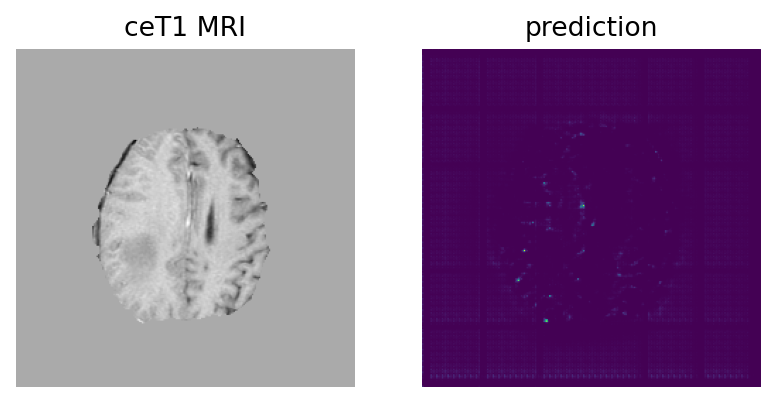

['/content/drive/MyDrive/data/brats18_test/Brats18_test_08/t1ce.nii.gz']


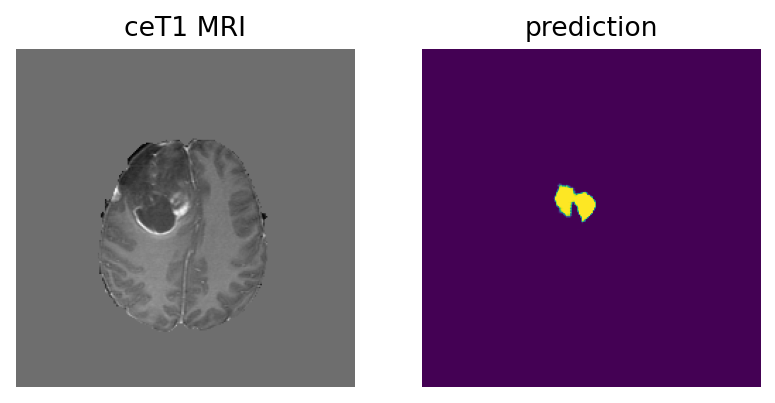

['/content/drive/MyDrive/data/brats18_test/Brats18_test_09/t1ce.nii.gz']


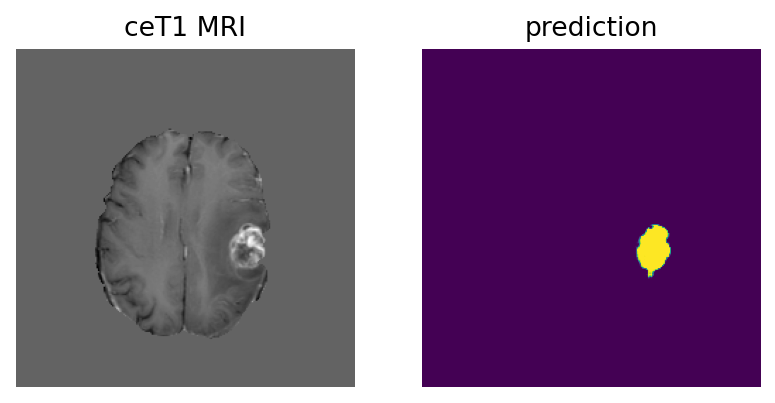

['/content/drive/MyDrive/data/brats18_test/Brats18_test_10/t1ce.nii.gz']


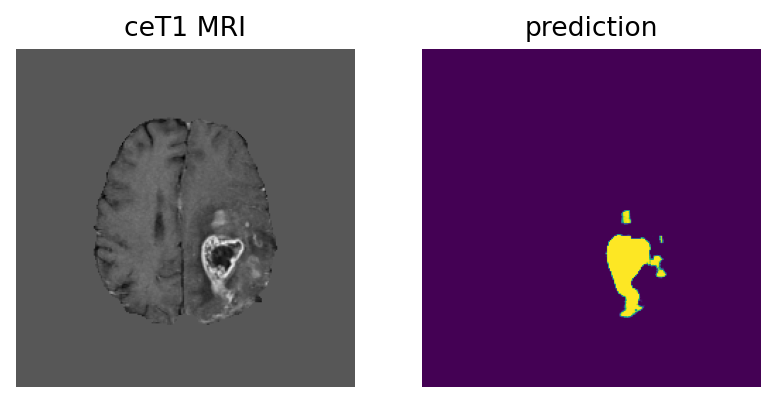

['/content/drive/MyDrive/data/brats18_test/Brats18_test_07/t1ce.nii.gz']


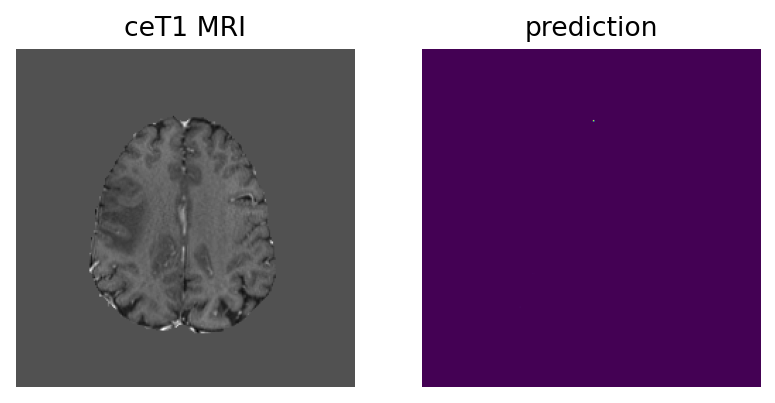

['/content/drive/MyDrive/data/brats18_test/Brats18_test_15/t1ce.nii.gz']


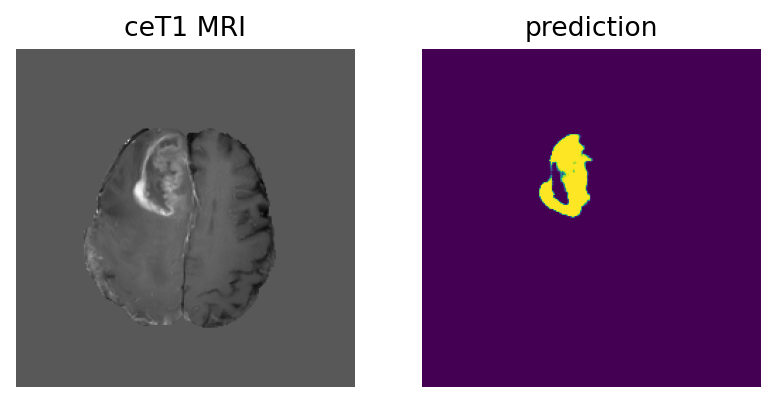

['/content/drive/MyDrive/data/brats18_test/Brats18_test_12/t1ce.nii.gz']


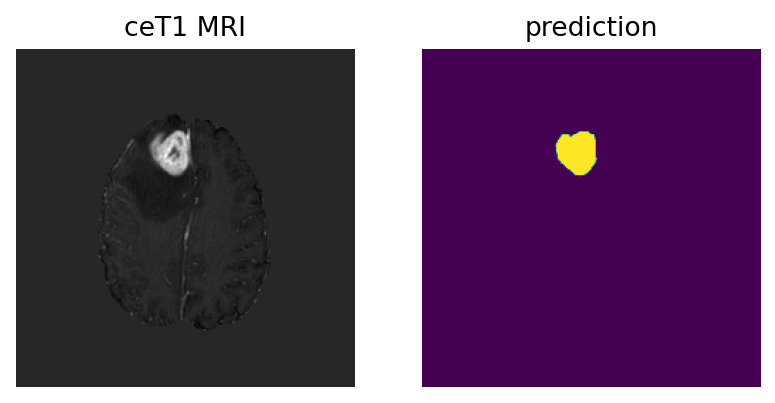

['/content/drive/MyDrive/data/brats18_test/Brats18_test_14/t1ce.nii.gz']


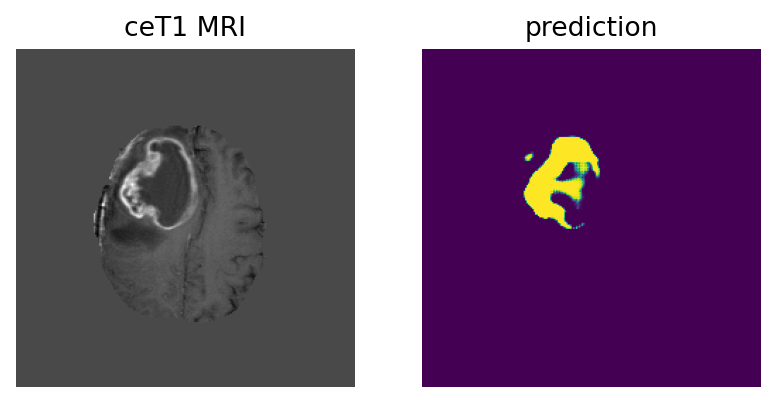

['/content/drive/MyDrive/data/brats18_test/Brats18_test_13/t1ce.nii.gz']


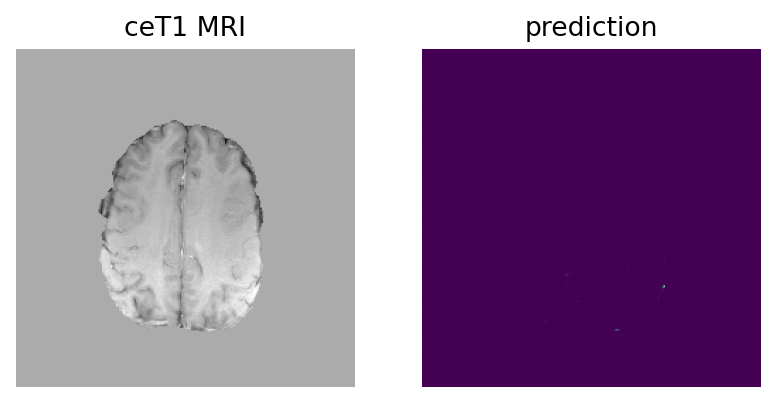

['/content/drive/MyDrive/data/brats18_test/Brats18_test_16/t1ce.nii.gz']


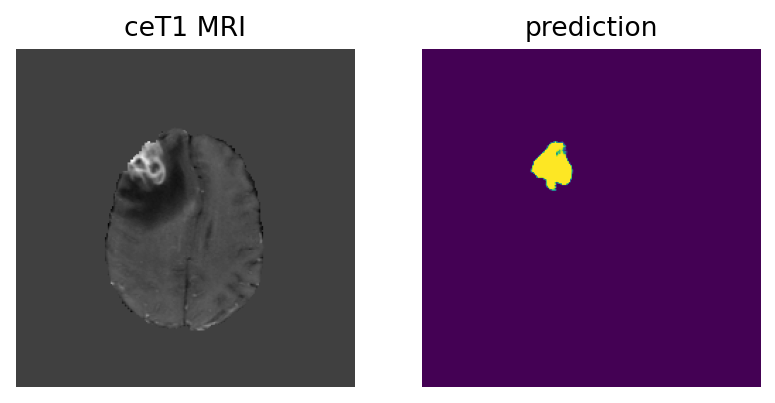

['/content/drive/MyDrive/data/brats18_test/Brats18_test_17/t1ce.nii.gz']


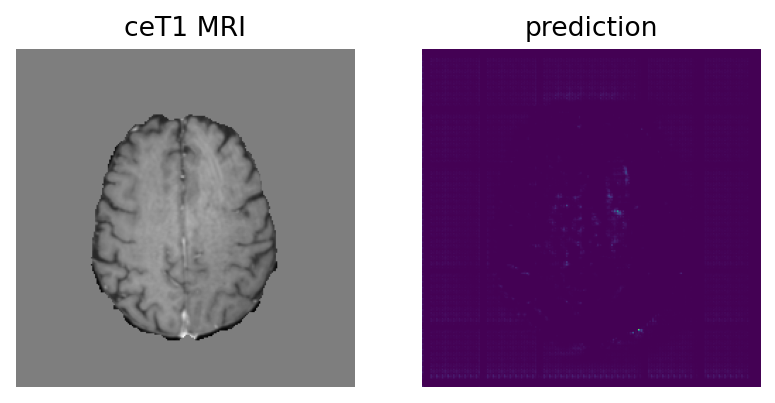

['/content/drive/MyDrive/data/brats18_test/Brats18_test_20/t1ce.nii.gz']


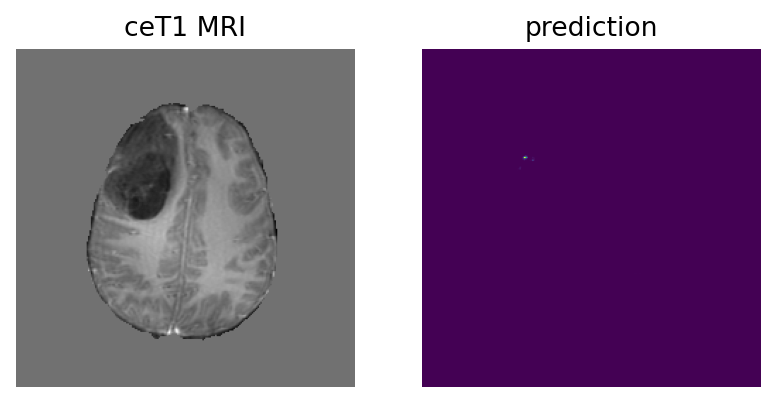

['/content/drive/MyDrive/data/brats18_test/Brats18_test_18/t1ce.nii.gz']


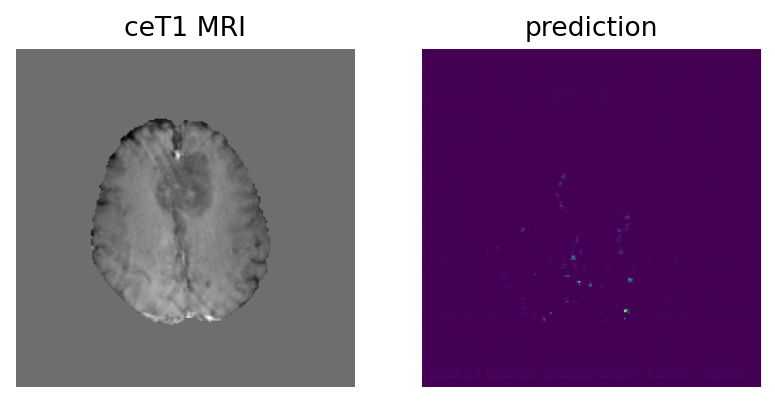

['/content/drive/MyDrive/data/brats18_test/Brats18_test_19/t1ce.nii.gz']


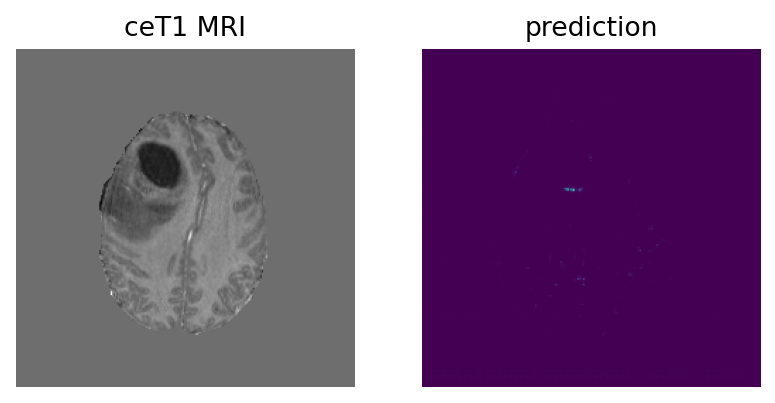

In [ ]:
model.eval()
flag_save = 1

# test data 불러옴
# inference 진행
for ts_data in ts_loader:
  with torch.no_grad():
    ts_inputs, ts_labels = (
                      ts_data["image"].to(device),
                      ts_data["label"],
                  ) 

    roi_size = (160, 160, 64)
    sw_batch_size = 1
    val_outputs = sliding_window_inference(
    ts_inputs, roi_size, sw_batch_size, model, overlap=0.75)

  
    print(ts_data['image_meta_dict']['filename_or_obj'])
    zz=100
    #zz = np.argmax(np.sum(np.sum(np.array(ts_labels[0,0,:,:,:].cpu()),axis=1),axis=0))
    val_preds = val_outputs.softmax(1)
    plt.figure(dpi=dpiv*2)
    plt.subplot(121)
    plt.imshow(np.transpose(ts_inputs[0,0,:,:,zz].cpu().numpy(),(1,0)),cmap='gray')
    plt.axis('off')
    plt.title('ceT1 MRI')
    plt.subplot(122)
    plt.imshow(np.transpose(val_preds[0,1,:,:,zz].cpu().numpy(),(1,0)))
    plt.axis('off')
    plt.title('prediction')
    plt.show()

  # nifti 파일 만드는 과정
    if flag_save == 1:
      val_seg = torch.argmax(val_preds.cpu(),dim=1).numpy()
      pid = ts_data['image_meta_dict']['filename_or_obj'][0].split('/')[-2]
      h = nib.load(ts_data['image_meta_dict']['filename_or_obj'][0])
      h_new=nib.Nifti1Image(val_seg[0],h.affine,h.header)
      nib.save(h_new,os.path.join(path_out,pid+'.nii.gz'))

  # 만들어진 nifti 파일 다운로드해서 원본 이미지랑 잘 매칭이 되는지 확인 후 제출
